In [1]:
import os
import boto3
from dotenv import load_dotenv
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
load_dotenv()

True

In [3]:
# Custom function to reduce memory usage of data

def reduce_mem_usage(df, verbose=True):
    numerics = ['int8','int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float32)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [4]:
AWS_S3_BUCKET = os.getenv("AWS_S3_BUCKET")
AWS_ACCESS_KEY_ID = os.getenv("AWS_ACCESS_KEY_ID")
AWS_SECRET_ACCESS_KEY = os.getenv("AWS_SECRET_ACCESS_KEY")

In [5]:
s3_client = boto3.client(
    "s3",
    aws_access_key_id=AWS_ACCESS_KEY_ID,
    aws_secret_access_key=AWS_SECRET_ACCESS_KEY
)

response = s3_client.get_object(Bucket=AWS_S3_BUCKET, Key="processed/tcga_processed.csv")

status = response.get("ResponseMetadata", {}).get("HTTPStatusCode")

if status == 200:
    print(f"Successful S3 get_object response. Status - {status}")
    df = reduce_mem_usage(pd.read_csv(response.get("Body")))
    print(df.info())
else:
    print(f"Unsuccessful S3 get_object response. Status - {status}")

Successful S3 get_object response. Status - 200
Mem. usage decreased to  0.94 Mb (86.4% reduction)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13020 entries, 0 to 13019
Data columns (total 70 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Primary_Site                    13020 non-null  int8   
 1   Deceased_Status                 13020 non-null  int8   
 2   Age_At_Diagnosis                13020 non-null  float32
 3   Sex                             13020 non-null  int8   
 4   Prior_Malignancy                13020 non-null  int8   
 5   Synchronous_Malignancy          13020 non-null  int8   
 6   TP53                            13020 non-null  int8   
 7   PIK3CA                          13020 non-null  int8   
 8   TTN                             13020 non-null  int8   
 9   CDH1                            13020 non-null  int8   
 10  GATA3                           13020 non-null  int8   

In [6]:
final_df = df.drop('Weight', axis=1)

In [7]:
final_df.head()

,Primary_Site,Deceased_Status,Age_At_Diagnosis,Sex,Prior_Malignancy,Synchronous_Malignancy,TP53,PIK3CA,TTN,CDH1,...,BTG2,B2M,PIM1,IGHG1,SPOP,FOXA1,Race_asian,Race_black or african american,Race_other,Race_white
0,0,0,9.602739,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,0,0,6.375342,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,16.753426,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,16.038357,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,14.052054,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [8]:
final_df.shape

(13020, 69)

## Distribution of target classes

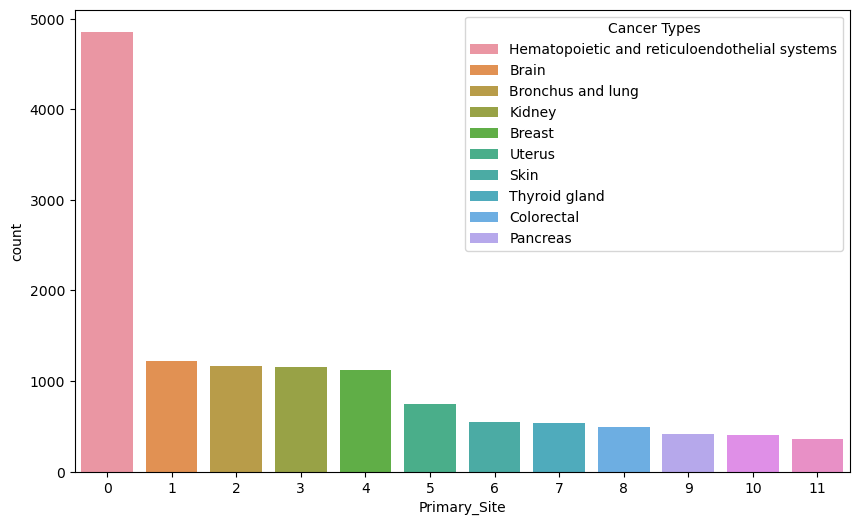

In [9]:
plt.figure(figsize=(10,6))
ax = sns.countplot(data = final_df, x = 'Primary_Site', hue='Primary_Site', dodge=False)
h,l = ax.get_legend_handles_labels()
labels=['Hematopoietic and reticuloendothelial systems', 
                   'Brain',
                   'Bronchus and lung',
                   'Kidney',
                   'Breast',
                   'Uterus', 
                   'Skin', 
                   'Thyroid gland', 
                   'Colorectal',
                   'Pancreas']
ax.legend(h,labels,title="Cancer Types", loc="upper right") 
plt.show()

As demonstrated in the plot above, the classes have a severe imbalance problem, especially for class 0 which pertains to Myeloid cancers. Therefore, the weight column is used to address the imbalance in the model.

## Distributions of target classes by age at diagnosis

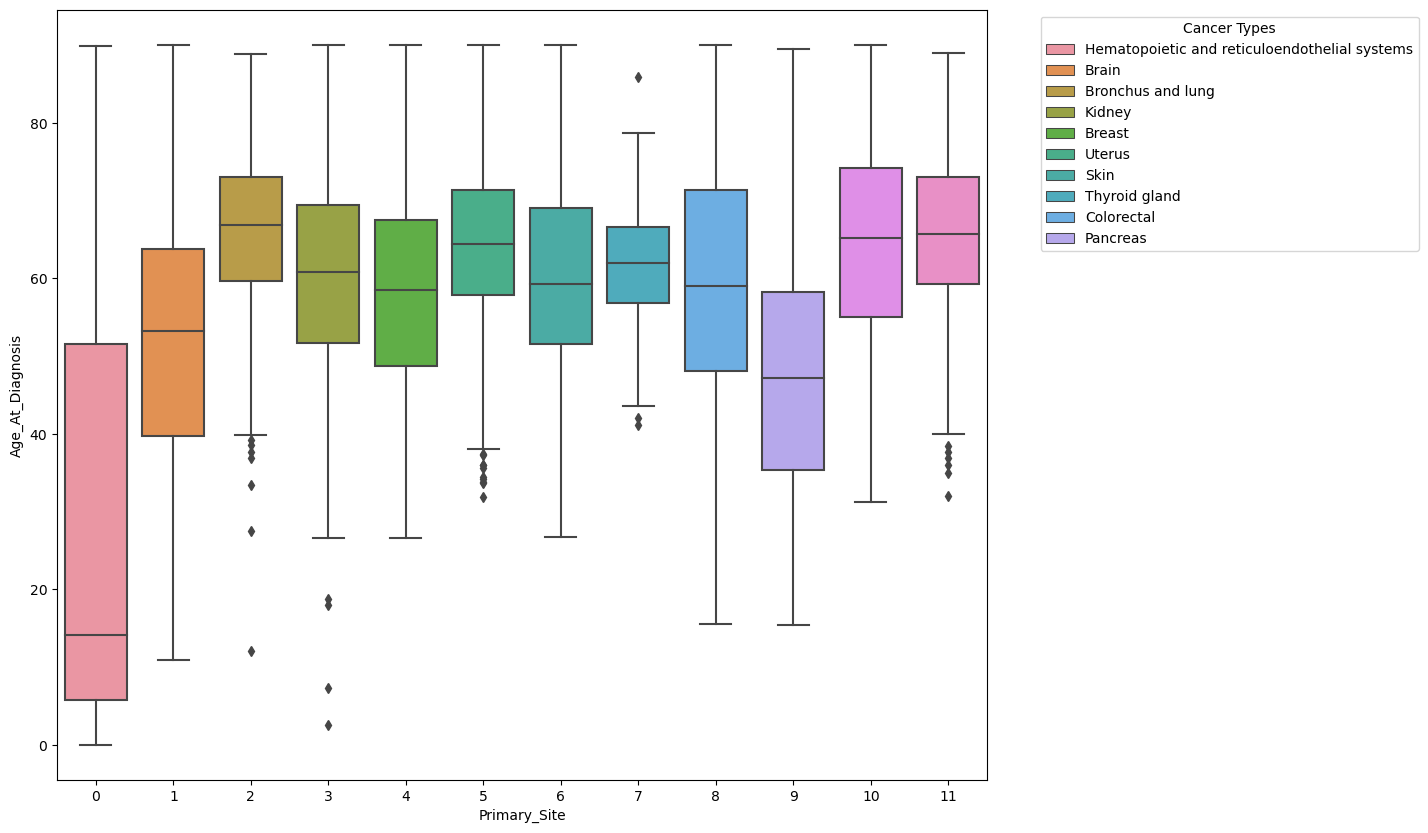

In [10]:
plt.figure(figsize=(12,10))
ax = sns.boxplot(data = final_df, x = 'Primary_Site', y='Age_At_Diagnosis', hue='Primary_Site', dodge=False)
h,l = ax.get_legend_handles_labels()
labels=['Hematopoietic and reticuloendothelial systems', 
                   'Brain',
                   'Bronchus and lung',
                   'Kidney',
                   'Breast',
                   'Uterus', 
                   'Skin', 
                   'Thyroid gland', 
                   'Colorectal',
                   'Pancreas']
ax.legend(h,labels,title="Cancer Types", bbox_to_anchor= (1.05,1))
plt.show()

## Distribution of Sexes

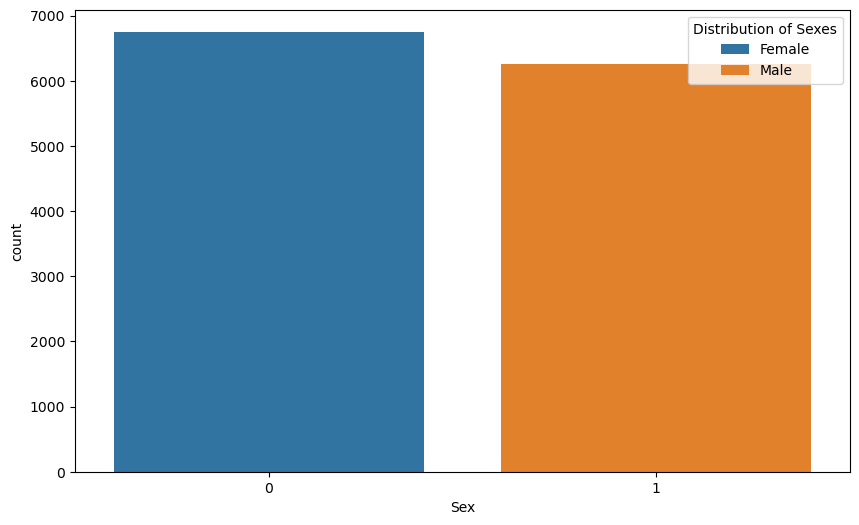

In [12]:
plt.figure(figsize=(10,6))
ax = sns.countplot(data = final_df, x = 'Sex', hue='Sex', dodge=False)
h,l = ax.get_legend_handles_labels()
labels=['Female', 'Male']
ax.legend(h,labels,title="Distribution of Sexes", loc="upper right") 
plt.show()

## Correlation heat map for multicollinearity

In [13]:
final_df.corr()

,Primary_Site,Deceased_Status,Age_At_Diagnosis,Sex,Prior_Malignancy,Synchronous_Malignancy,TP53,PIK3CA,TTN,CDH1,...,BTG2,B2M,PIM1,IGHG1,SPOP,FOXA1,Race_asian,Race_black or african american,Race_other,Race_white
Primary_Site,1.000000,0.138420,0.468441,-0.113323,0.095735,0.006331,0.261376,0.146603,0.231978,0.062024,...,-0.010893,0.062813,-0.007880,0.053796,0.086409,0.057431,0.021213,-0.017973,0.034426,-0.010921
Deceased_Status,0.138420,1.000000,0.262616,-0.006430,0.029878,-0.011749,0.157916,-0.012619,0.100987,-0.019330,...,-0.005604,0.006481,-0.016555,0.023419,-0.027232,-0.023234,-0.031577,-0.047735,0.023409,0.047817
Age_At_Diagnosis,0.468441,0.262616,1.000000,-0.056350,0.154822,0.030967,0.277554,0.163873,0.299077,0.077754,...,0.033563,0.050542,0.044289,0.065589,0.063182,0.069086,-0.022011,-0.012197,0.019080,0.015464
Sex,-0.113323,-0.006430,-0.056350,1.000000,0.009724,0.020772,-0.066279,-0.166149,-0.004737,-0.078176,...,0.007637,-0.010881,0.005980,0.020563,0.014390,-0.008602,0.005722,-0.049037,0.004930,0.033977
Prior_Malignancy,0.095735,0.029878,0.154822,0.009724,1.000000,-0.011094,0.047136,0.043420,0.068197,0.035171,...,0.016330,0.001477,0.009579,0.024607,0.001081,-0.001480,-0.036791,0.006521,-0.030298,0.027625
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
FOXA1,0.057431,-0.023234,0.069086,-0.008602,-0.001480,0.009151,-0.003625,0.070099,0.061851,0.082247,...,-0.005575,0.019795,-0.006659,0.014708,0.087673,1.000000,-0.002840,0.001345,0.012414,-0.004060
Race_asian,0.021213,-0.031577,-0.022011,0.005722,-0.036791,-0.012561,0.047204,-0.001415,-0.005217,-0.012362,...,0.024287,0.005566,0.010488,0.002742,-0.007533,-0.002840,1.000000,-0.079994,-0.034305,-0.507569
Race_black or african american,-0.017973,-0.047735,-0.012197,-0.049037,0.006521,0.052866,0.011784,0.015302,-0.020435,0.005837,...,-0.005211,-0.009853,0.000360,-0.016763,0.023877,0.001345,-0.079994,1.000000,-0.049568,-0.733401
Race_other,0.034426,0.023409,0.019080,0.004930,-0.030298,-0.007783,0.019365,0.020941,0.015195,-0.006735,...,-0.008094,0.007493,0.022928,-0.014003,0.005924,0.012414,-0.034305,-0.049568,1.000000,-0.314511


Text(0.5, 1.0, 'Correlation Heatmap')

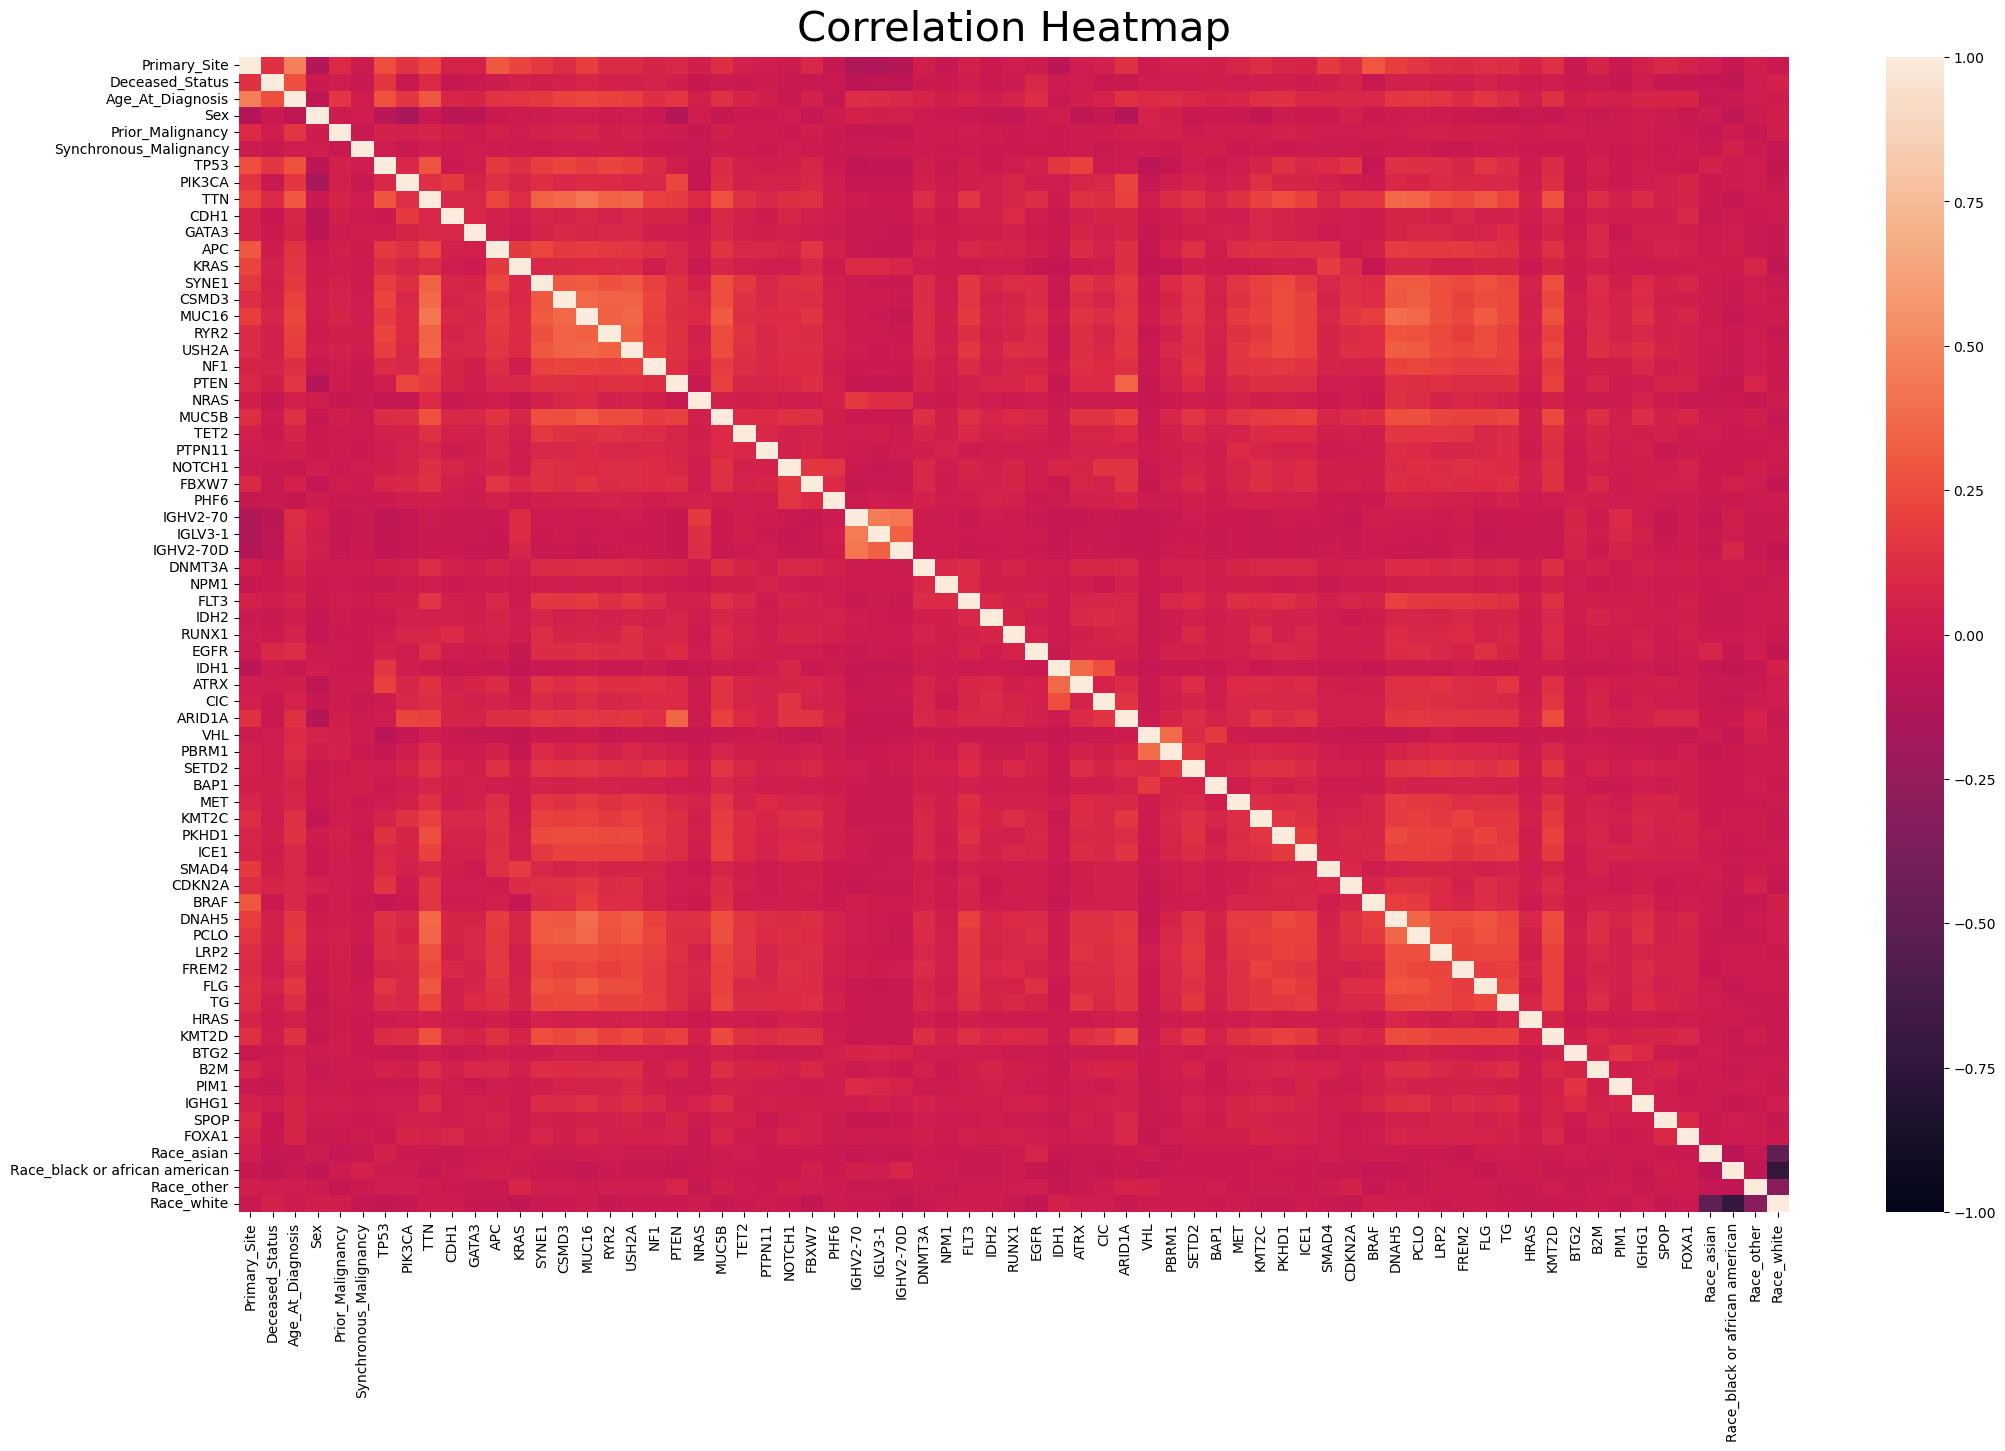

In [14]:
plt.figure(figsize=(25,15))
heatmap = sns.heatmap(final_df.corr(), vmin=-1, vmax=1, annot=False)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':30}, pad=12)

As illustrated above, the only features that exceed |0.70| in correlation are race_white and race_black, since they represented the majority of the cases' races.

## Distribution of races and ethnicities

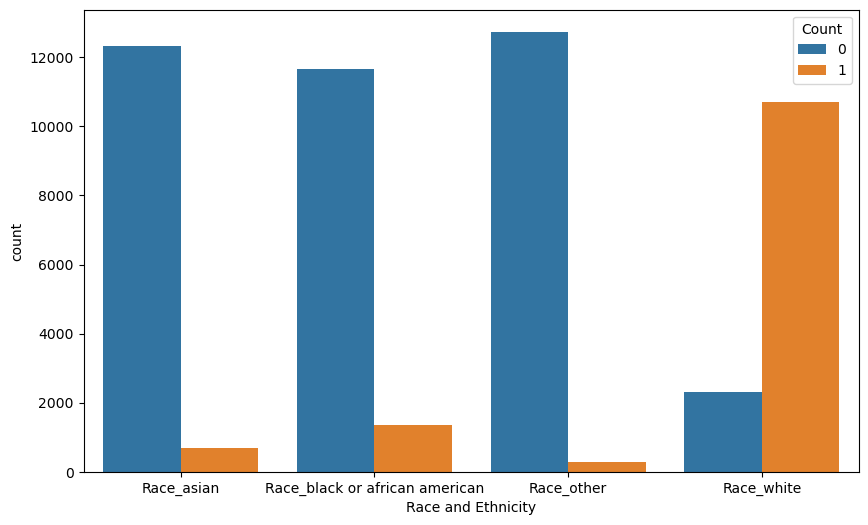

In [15]:
plt.figure(figsize=(10,6))

race_df = final_df[['Race_asian', 'Race_black or african american', 'Race_other', 'Race_white']]
race_df1 = race_df.melt(var_name='Race and Ethnicity', value_name='Count')
sns.countplot(x='Race and Ethnicity', hue='Count', data=race_df1)

plt.show()

## Distribution of ages

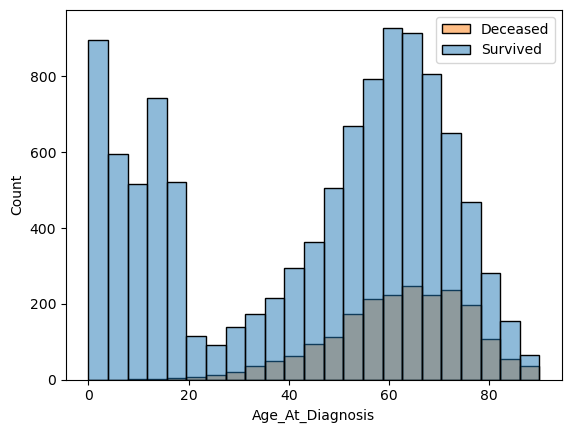

In [16]:
sns.histplot(data=final_df, x='Age_At_Diagnosis', hue='Deceased_Status')
plt.legend(labels=['Deceased', 'Survived'])
plt.show()

## Distribution of Prior Malignancies

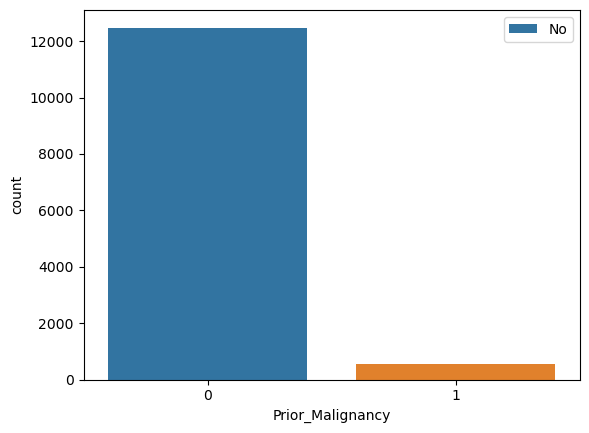

In [17]:
sns.countplot(data=final_df, x='Prior_Malignancy')
plt.legend(labels=['No', 'Yes'])
plt.show()

## Distribution of Synchronous Malignancies

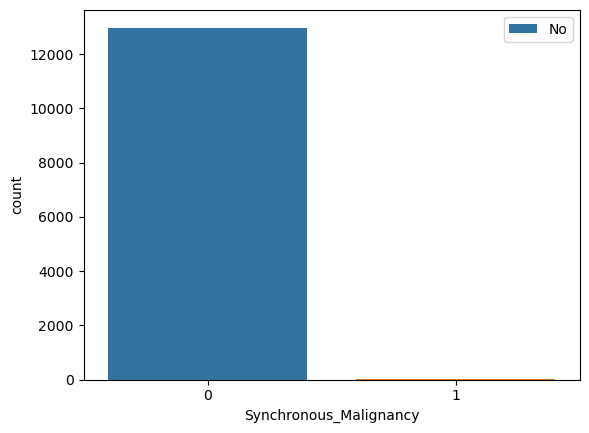

In [18]:
sns.countplot(data=final_df, x='Synchronous_Malignancy')
plt.legend(labels=['No', 'Yes'])
plt.show()